## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

<ipython-input-3-7c6b28fd588a>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-0.458,0.832,-1.997,1.127,0.015,0.013,3252.0,2478.0,1.0
betas[1],-0.573,0.728,-1.931,0.813,0.013,0.011,2943.0,2821.0,1.0
betas[2],0.683,0.611,-0.507,1.816,0.013,0.009,2217.0,2509.0,1.0
betas[3],-0.207,0.332,-0.818,0.408,0.007,0.005,2365.0,2523.0,1.0
betas[4],-0.386,0.870,-2.002,1.233,0.016,0.013,3048.0,2663.0,1.0
betas[5],0.134,0.138,-0.137,0.382,0.002,0.002,3708.0,2114.0,1.0
betas[6],-2.331,0.700,-3.702,-1.107,0.013,0.009,2844.0,2269.0,1.0
intercept,-0.473,0.143,-0.729,-0.196,0.003,0.002,2695.0,2487.0,1.0


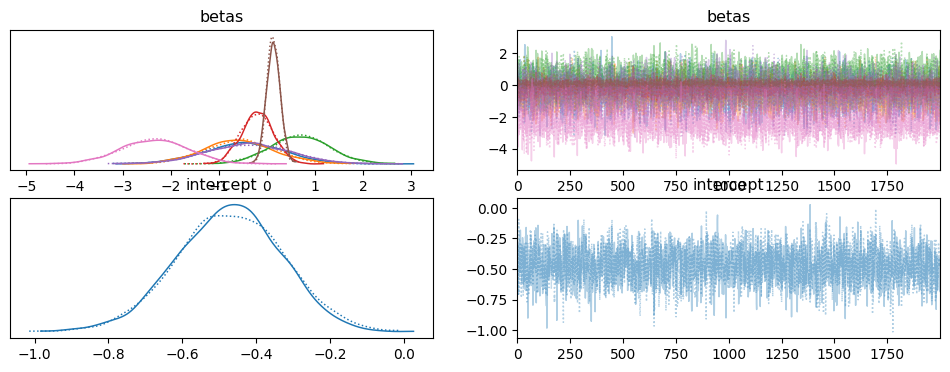

In [ ]:
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Raisin_Dataset.csv"

# Load dataset from Kaggle
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nimapourmoradi/raisin-binary-classification",
    file_path,
)

# Encode binary target variable
le = LabelEncoder()
df["Class"] = le.fit_transform(df["Class"])  # Convert 'Class' to 0/1

# Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["Class"]))
y = df["Class"].values

# Define Bayesian logistic regression model
with pm.Model() as logistic_model:

    # Priors for coefficients (normal distribution)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # Logit link function
    logits = intercept + pm.math.dot(X, betas)
    p = pm.math.sigmoid(logits)

    # Likelihood (Bernoulli distribution)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Inference using MCMC
    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)

# Posterior analysis
az.plot_trace(trace)
az.summary(trace)



### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [ ]:
file_path = "student_marks.csv"

# Load dataset from Kaggle
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "yapwh1208/students-score",
    file_path,
)

<ipython-input-10-8b6b338fd664>:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [ ]:
# Select relevant continuous features for multivariate regression
features = ["Test_1", "Test_2", "Test_3"]
df = df.dropna(subset=features)  # Drop missing values
X = df[features].values

# Define dimensions
n, p = X.shape  # n = samples, p = predictors
m = 2  # Number of continuous outcomes

# Generate synthetic target variable (assuming two continuous outputs for demonstration)
beta_ = np.ones((p, m))
a_cov = stats.invwishart(df=m + 2, scale=np.eye(m)).rvs()
x = X @ beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

# Bayesian Multivariate Regression Model
with pm.Model() as MNV_LKJ:

    # LKJ prior for covariance
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False,
    )
    L = pm.expand_packed_triangular(m, packed_L)

    # Normal priors for betas
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Covariance matrix
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))

    # Multivariate Normal likelihood
    y = pm.MvNormal("y", mu=X @ betas, chol=L, observed=x)

    # MCMC sampling
    idata = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>]], dtype=object)

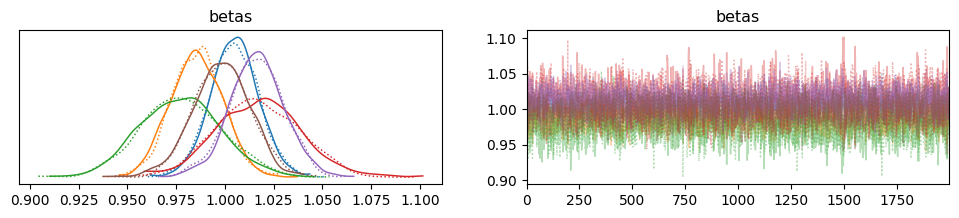

In [ ]:
import arviz as az

az.plot_trace(idata, var_names="betas")

2


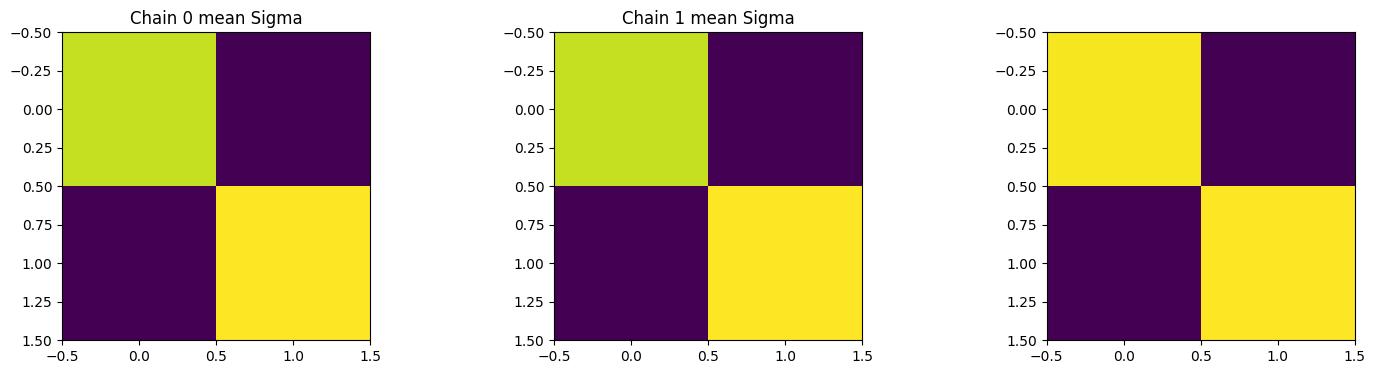

In [ ]:

num_chains = len(idata.posterior.chain)  # Get the actual number of chains
print(num_chains)
fig, ax = plt.subplots(1, num_chains + 1, figsize=(18, 4))  # Adjust the number of subplots
ax[-1].imshow(a_cov)
ax[0].set_title("Sigma used to generate y")

for chain in range(num_chains):
    ax[chain].imshow(idata.posterior["Sigma"].mean(dim=["draw"])[chain])
    ax[chain].set_title(f"Chain {chain} mean Sigma")


### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


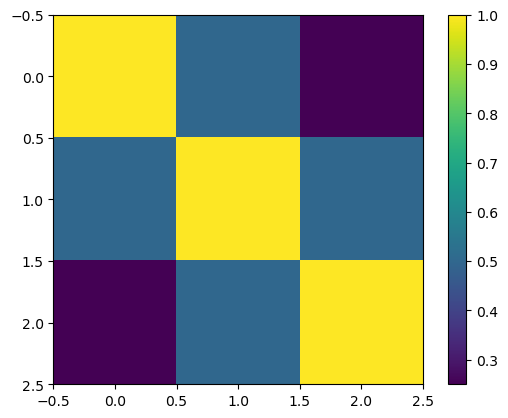

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "smoking_data.csv"
df = pd.read_csv(file_path)

# Preprocess dataset
binary_outcomes = ["gender", "hearing(right)"]
df["gender"] = df["gender"].map({"M": 1, "F": 0})
df["hearing(right)"] = df["hearing(right)"].map({1: 1, 2: 0})

# Select features (Reduced for faster computation)
features = ["age", "height(cm)"]
X = StandardScaler().fit_transform(df[features].values)
y = df[binary_outcomes].values

n, p = X.shape
m = y.shape[1]

In [ ]:
with pm.Model() as GLM:
    L, R, std = pm.LKJCholeskyCov(
        "R", n=m, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=m), compute_corr=True
    )
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    z = pm.MvNormal("z", mu=pm.math.dot(X, betas), cov=R, shape=(n, m))
    y_obs = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=y)
    idata = pm.sample(1000, tune=500, target_accept=0.85, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1424 divergences after tuning. Increase `target_accept` or reparameterize.


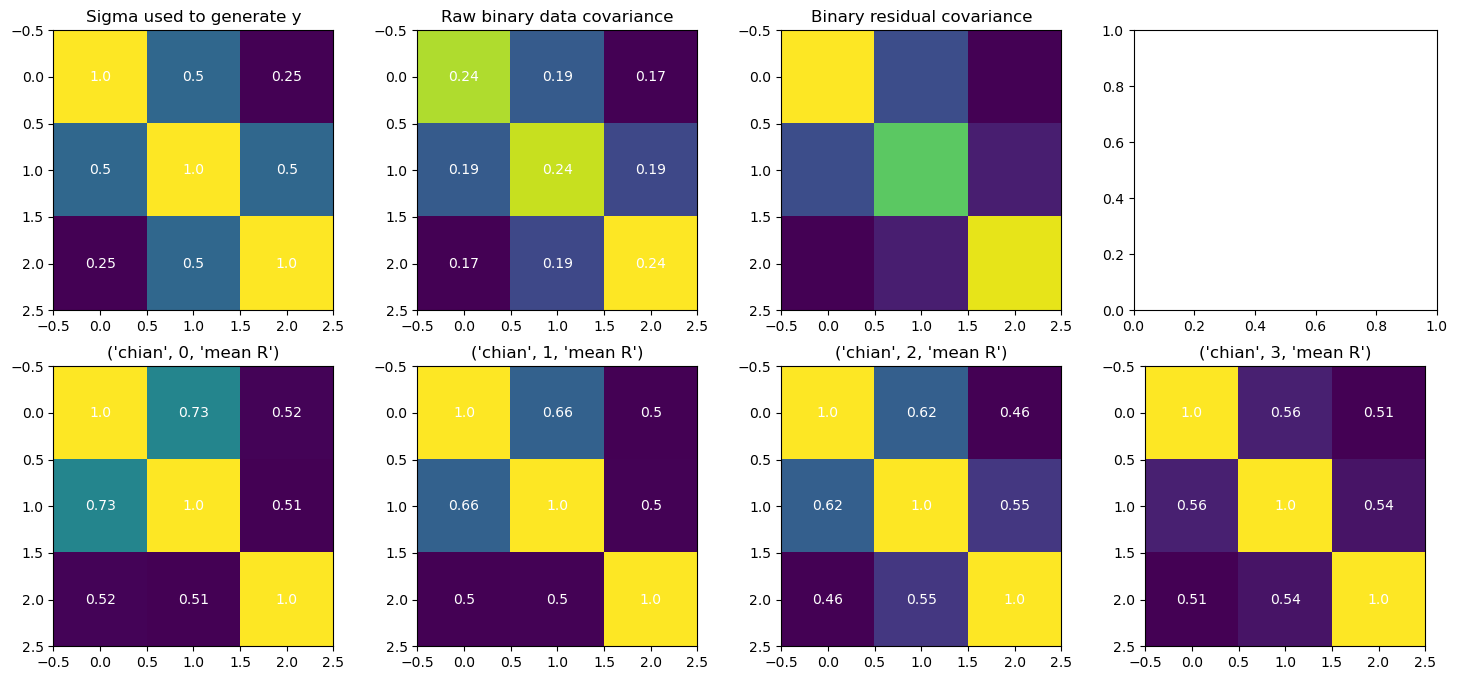

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(18, 8))
for chain in range(4):
    ax[1, chain].imshow(idata.posterior["R_corr"].mean(axis=1)[chain])
    for i in range(m):
        for j in range(m):
            ax[1, chain].text(
                i, j, str(round(idata.posterior["R_corr"].mean(axis=1)[chain].values[j, i], 2)),
                c="w", ha="center", va="center"
            )
    ax[1, chain].set_title(f"Chain {chain} Mean R")

az.plot_trace(idata, var_names=["betas", "R_corr"])
plt.show()

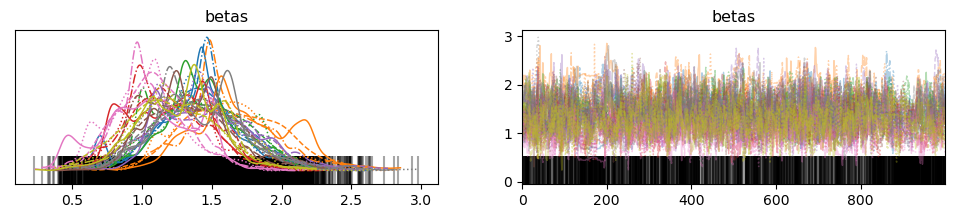

In [ ]:
az.plot_trace(idata, var_names="betas")